In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
train_data = datasets.FashionMNIST(
    root = 'data',
    download = True,
    train = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = 'data',
    download = True,
    train = False,
    transform = ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11622263.47it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 206890.65it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3685186.63it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21315179.66it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
image, label = train_data[0]
image, label

In [ ]:
len(train_data[0])

2

In [ ]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
type(train_data)
print(len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets))

60000 60000 10000 10000


In [ ]:
class_name = train_data.classes

Image shape: torch.Size([1, 28, 28])


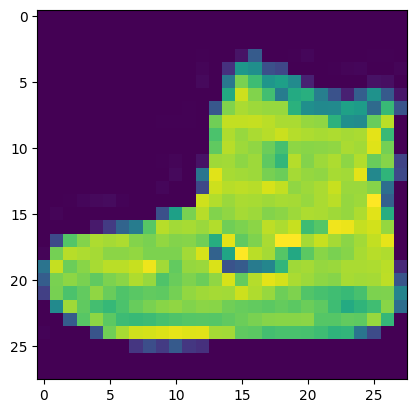

In [ ]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())


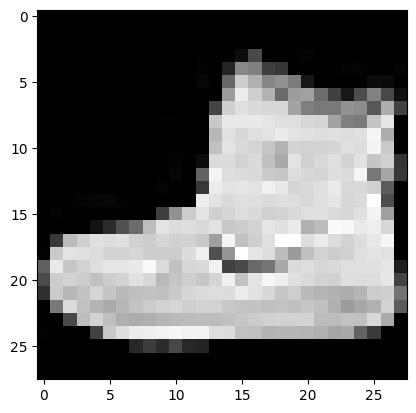

In [ ]:
plt.imshow(image.squeeze(), cmap = 'gray')

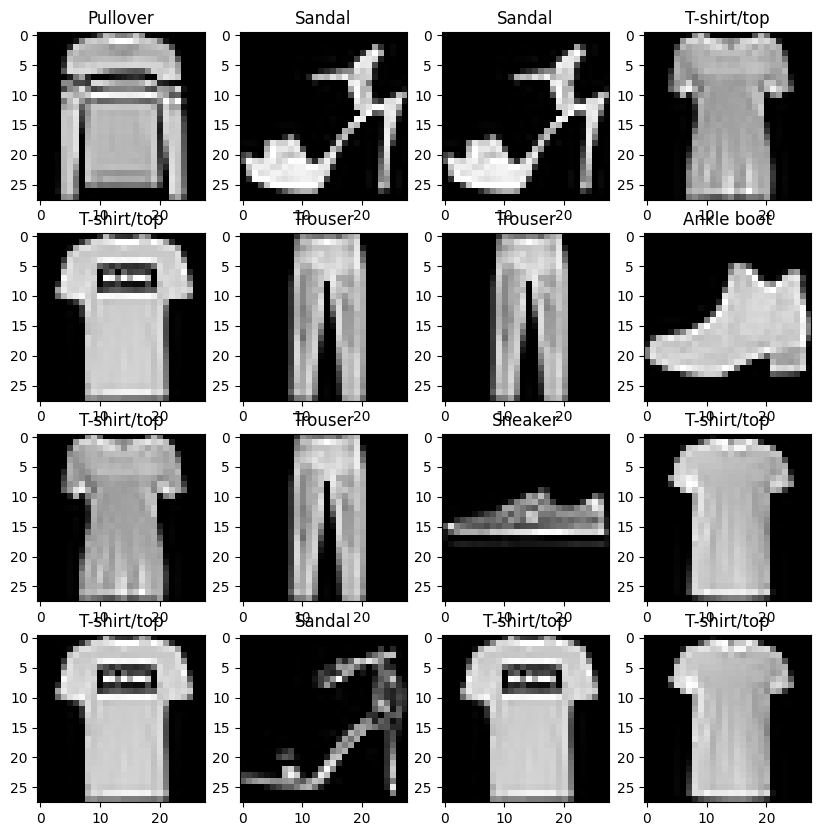

In [ ]:
import random
torch.manual_seed(42)
fig = plt.figure(figsize = (10,10))
row, col = 4,4
for i in range(1, row * col + 1):
  random_idx = random.randint(1, row * col + 1)
  img, labels = train_data[random_idx]
  fig.add_subplot(row, col, i)
  plt.imshow(img.squeeze(), cmap = 'gray')
  plt.title(class_name[labels])

In [ ]:
from torch.utils.data import DataLoader
train_data_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_data_loader = DataLoader(test_data, batch_size = 32, shuffle = False)
print(len(train_data_loader))
print(len(test_data_loader))

1875
313


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_data_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
import torch.nn
flatten_model = nn.Flatten()

x = train_features_batch[0]
output = flatten_model(x)
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [ ]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_unit):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features= hidden_unit),
        nn.Linear(in_features= hidden_unit, out_features= output_shape)
    )
  def forward(self,x):
    return self.layer_stack(x)


In [ ]:
model_0 = FashionMNISTModelV0(input_shape = 784, output_shape= len(class_name), hidden_unit= 10)
model_0.to("cpu")


FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = 0
  for i in range(len(y_true)):
    if(y_true[i].item() == y_pred[i].item()):
      correct += 1
  acc = (correct / len(y_pred)) * 100
  return acc


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)


In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
len(train_data_loader)

1875

In [ ]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

In [ ]:
(X,y) = next(iter(train_data_loader))
print(y.shape)

torch.Size([32])


In [ ]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(42)
start_time = timer()
epochs = 3
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-----------")
  train_loss = 0
  for batch, (X,y) in enumerate(train_data_loader):
    model_0.train()
    y_pred = model_0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 400 == 0:
      print(f"Look at {batch * len(X)}/{len(train_data_loader.dataset)} sample")
  train_loss /= len(train_data_loader)
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_data_loader:
      test_pred = model_0(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true= y, y_pred = test_pred.argmax(dim = 1))
    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
end_time = timer()
total_train_time_model_0 = print_train_time(start=start_time,
                                           end=end_time,
                                           device=str(next(model_0.parameters()).device))




Epoch: 0
-----------
Look at 0/60000 sample
Look at 12800/60000 sample
Look at 25600/60000 sample
Look at 38400/60000 sample
Look at 51200/60000 sample

Train loss: 0.40134 | Test loss: 0.46278, Test acc: 84.09%

Epoch: 1
-----------
Look at 0/60000 sample
Look at 12800/60000 sample
Look at 25600/60000 sample
Look at 38400/60000 sample
Look at 51200/60000 sample

Train loss: 0.40134 | Test loss: 0.46278, Test acc: 84.09%

Epoch: 2
-----------
Look at 0/60000 sample
Look at 12800/60000 sample
Look at 25600/60000 sample
Look at 38400/60000 sample
Look at 51200/60000 sample

Train loss: 0.40134 | Test loss: 0.46278, Test acc: 84.09%

Train time on cpu: 28.323 seconds


In [ ]:
torch.manual_seed(42)

def evaluate_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  model.eval()
  loss, acc = 0, 0
  with torch.inference_mode():
    for X, y in data_loader:
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss,
            "model_acc": acc}

model_0_results = evaluate_model(model=model_0, data_loader=test_data_loader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': tensor(0.4628),
 'model_acc': 84.08546325878594}

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape, hidden_unit, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features= hidden_unit),
        nn.ReLU(),
        nn.Linear(in_features= hidden_unit, out_features= output_shape),
        nn.ReLU()
        )
  def forward(self, x):
    return self.layer_stack(x)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model_1 = FashionMNISTModelV1(input_shape = 784, hidden_unit= 10, output_shape = len(class_name)).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [ ]:
X, y = next(iter(train_data_loader))

In [ ]:
print(type(y[0].item()))


<class 'int'>


In [ ]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.to(device)
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)

    train_loss += loss
    train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1)) #y_pred có đầu ra là 10 vì mạng CNN có output_size là 10 số cho 10 lớp nhưng y_true chỉ có số max nhất

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss}/ Train accuracy: {train_acc}\n")

def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  for X, y in data_loader:
    X, y = X.to(device), y.to(device)
    test_pred = model(X)
    test_loss += loss_fn(test_pred, y)
    test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))
  test_loss /= len(data_loader)
  test_acc /= len(data_loader)
  print(f"Test loss: {test_loss}/ Test accuracy: {test_acc}\n")



In [ ]:
from timeit import default_timer as timer

start_time = timer()
epochs = 3
for epoch in range(epochs):
  train_step(model_1, train_data_loader, loss_fn, optimizer, accuracy_fn)
  test_step(model_1, train_data_loader, loss_fn, optimizer, accuracy_fn)

end_time = timer()
print('Time on GPU: ', end_time - start_time)

Train loss: 0.6996486783027649/ Train accuracy: 74.67

Test loss: 0.6680575609207153/ Test accuracy: 75.685

Train loss: 0.6654557585716248/ Train accuracy: 75.59666666666666

Test loss: 0.6429437398910522/ Test accuracy: 76.19666666666667

Train loss: 0.643391489982605/ Train accuracy: 76.205

Test loss: 0.6209468841552734/ Test accuracy: 77.09833333333333

Time on GPU:  48.553182467999704


In [ ]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
  loss, acc = 0, 0
  model.eval()
  #with torch.inference_mode():
  for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
  loss /= len(data_loader)
  acc /= len(data_loader)
  return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

model_1_results = eval_model(model=model_1, data_loader=test_data_loader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6703859567642212,
 'model_acc': 75.78873801916933}

In [ ]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [ ]:
layer_1 = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, stride = 1, padding = 'same')
res = layer_1(test_image)
print(res.shape)

torch.Size([10, 64, 64])


In [ ]:
X, y = next(iter(train_data_loader))
type(X)

torch.Tensor

In [ ]:
X.shape

torch.Size([32, 1, 28, 28])

In [ ]:
X[0].shape

torch.Size([1, 28, 28])

In [ ]:
layer_1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1, padding = 'same')
res = layer_1(X[0])
print(res.shape)

torch.Size([10, 28, 28])


In [ ]:
layer_1.state_dict()

OrderedDict([('weight',
              tensor([[[[ 0.2928,  0.0583,  0.1504],
                        [ 0.1493, -0.0441,  0.2612],
                        [-0.1877, -0.2767, -0.0309]]],
              
              
                      [[[ 0.2406,  0.3269, -0.0508],
                        [-0.3270,  0.0633, -0.1278],
                        [-0.2631, -0.0772, -0.2733]]],
              
              
                      [[[ 0.0068, -0.1100,  0.2334],
                        [ 0.2409,  0.2382, -0.1691],
                        [-0.2075, -0.0192,  0.0323]]],
              
              
                      [[[ 0.1044,  0.0073, -0.0541],
                        [-0.0472, -0.3129, -0.2519],
                        [ 0.2119,  0.0333,  0.3224]]],
              
              
                      [[[-0.3168, -0.1030,  0.1550],
                        [ 0.0952, -0.0553,  0.3226],
                        [-0.1256, -0.2723,  0.3054]]],
              
              
                     

In [ ]:

class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape, hidden_unit, output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape, out_channels= hidden_unit, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_unit, out_channels= hidden_unit, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_unit, hidden_unit, 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_unit, hidden_unit, 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_unit*7*7, output_shape)
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

model_2 = FashionMNISTModelV2(1, 10, len(class_name)).to(device)
model_2

'''
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_name)).to(device)
model_2
'''

'\n# Create a convolutional neural network \nclass FashionMNISTModelV2(nn.Module):\n    """\n    Model architecture copying TinyVGG from: \n    https://poloclub.github.io/cnn-explainer/\n    """\n    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):\n        super().__init__()\n        self.block_1 = nn.Sequential(\n            nn.Conv2d(in_channels=input_shape, \n                      out_channels=hidden_units, \n                      kernel_size=3, # how big is the square that\'s going over the image?\n                      stride=1, # default\n                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number \n            nn.ReLU(),\n            nn.Conv2d(in_channels=hidden_units, \n                      out_channels=hidden_units,\n                      kernel_size=3,\n                      stride=1,\n                      padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(kern

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

In [ ]:
epochs = 3
start_time = timer()
for epoch in range(epochs):
  train_step(model_2, train_data_loader, loss_fn, optimizer, accuracy_fn)
  test_step(model_2, test_data_loader, loss_fn, optimizer, accuracy_fn)

end_time = timer()

print("Time on GPU: ", end_time - start_time)

Train loss: 0.2955223023891449/ Train accuracy: 89.30166666666666

Test loss: 0.31137436628341675/ Test accuracy: 89.1673322683706

Train loss: 0.2809220850467682/ Train accuracy: 89.795

Test loss: 0.28459692001342773/ Test accuracy: 89.63658146964856

Train loss: 0.27039021253585815/ Train accuracy: 90.185

Test loss: 0.3137517273426056/ Test accuracy: 87.92931309904154

Time on GPU:  36.38894648600035


In [ ]:
model_2_result = evaluate_model(model_2, test_data_loader, loss_fn, accuracy_fn)
model_2_result

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
def evaluate_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
  model.to(device)
  model.eval()
  loss, acc = 0, 0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss,
            "model_acc": acc}

In [ ]:
model_2_result = evaluate_model(model_2, test_data_loader, loss_fn, accuracy_fn)
model_2_result

{'model_name': 'FashionMNISTModelV2',
 'model_loss': tensor(0.3138, device='cuda:0'),
 'model_acc': 87.92931309904154}

In [ ]:
model_1_result = evaluate_model(model_1, test_data_loader, loss_fn, accuracy_fn)
model_1_result

{'model_name': 'FashionMNISTModelV1',
 'model_loss': tensor(0.6704, device='cuda:0'),
 'model_acc': 75.78873801916933}

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_result, model_2_result])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,tensor(0.4628),84.085463
1,FashionMNISTModelV1,"tensor(0.6704, device='cuda:0')",75.788738
2,FashionMNISTModelV2,"tensor(0.3138, device='cuda:0')",87.929313
